## Exploratory Analysis

In this notebook, we conduct exploratory analysis on a representative sample of the Steam ecosystem to better understand the data used in our bundle recommendation task. 

Because the full Steam datasets are extremely large, we first sample 50,000 reviews from the first 200,000 lines of `steam_reviews.json.gz`, extract all associated game IDs, and then link these reviews to the full game metadata from `steam_games.json.gz`. This produces an "enriched" review dataset containing both user–item interaction signals (such as hours played and review text) and game-level attributes (such as genres, tags, specs, and price). 

We also draw a 5,000-entry sample from `bundle_data.json.gz` to examine bundle composition and size. Using these samples, we compute basic missingness statistics and generate core EDA plots including hours played, review length, genre frequencies, and bundle size distribution. 

These visualizations provide essential context about engagement patterns, metadata structure, and bundle characteristics, and they support the modeling assumptions used later in the project.

In [2]:
import gzip
import ast
import random

def sample_head_json_gz(path, max_lines=200000, sample_size=20000, seed=0):
    """
    Read up to `max_lines` lines from a .json.gz file and then
    take a uniform random sample of size `sample_size` from them.
    """
    random.seed(seed)
    records = []
    with gzip.open(path, 'rt', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i >= max_lines:
                break
            line = line.strip()
            if not line:
                continue
            obj = ast.literal_eval(line)
            records.append(obj)

    if len(records) <= sample_size:
        return records  # not enough to subsample, just return all

    return random.sample(records, sample_size)

In [3]:
reviews_sample = sample_head_json_gz(
    "dataset/steam_reviews.json.gz",
    max_lines=200000,
    sample_size=50000,
    seed=42
)

In [4]:
games_sample = sample_head_json_gz(
    "dataset/steam_games.json.gz",
    max_lines=50000,   # games file is much smaller anyway
    sample_size=5000,
    seed=42
)

In [5]:
bundle_sample = sample_head_json_gz(
    "dataset/bundle_data.json.gz",
    max_lines=200000,   # games file is much smaller anyway
    sample_size=5000,
    seed=42
)

In [ ]:
import gzip, ast

# 1. Collect all product_ids from your review sample
review_ids = {str(r["product_id"]) for r in reviews_sample}

# 2. Scan the FULL games file and keep only matching ids
game_index = {}

with gzip.open("dataset/steam_games.json.gz", "rt", encoding="utf-8") as f:
    for line in f:
        g = ast.literal_eval(line)
        gid = str(g.get("id"))
        if gid in review_ids:
            game_index[gid] = g

# 3. Build enriched review records by attaching game metadata
enriched_reviews = []
for r in reviews_sample:
    gid = str(r["product_id"])
    if gid in game_index:
        enriched_reviews.append({**r, **{
            "game_" + k: v
            for k, v in game_index[gid].items()
        }})

In [9]:
import pandas as pd

df = pd.DataFrame(enriched_reviews)

### Bundle Size Distribution

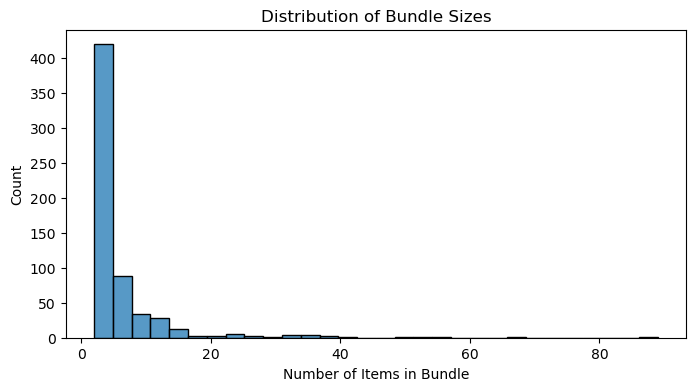

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract bundle sizes
bundle_sizes = [len(b.get("items", [])) for b in bundle_sample]

plt.figure(figsize=(8, 4))
sns.histplot(bundle_sizes, bins=30)
plt.title("Distribution of Bundle Sizes")
plt.xlabel("Number of Items in Bundle")
plt.ylabel("Count")
plt.show()

In [21]:
print("Mean bundle size:", pd.Series(bundle_sizes).mean())
print("Median bundle size:", pd.Series(bundle_sizes).median())
print("Max bundle size:", pd.Series(bundle_sizes).max())

Mean bundle size: 5.7317073170731705
Median bundle size: 3.0
Max bundle size: 89


Most bundles have 2 or 3 games in them. Highly skewed to the right.

### Genre Distribution Across Games in Sample

C:\Users\rsl\AppData\Local\Temp\ipykernel_25480\3651040031.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=genre_df, y="genre", x="count", palette="viridis")


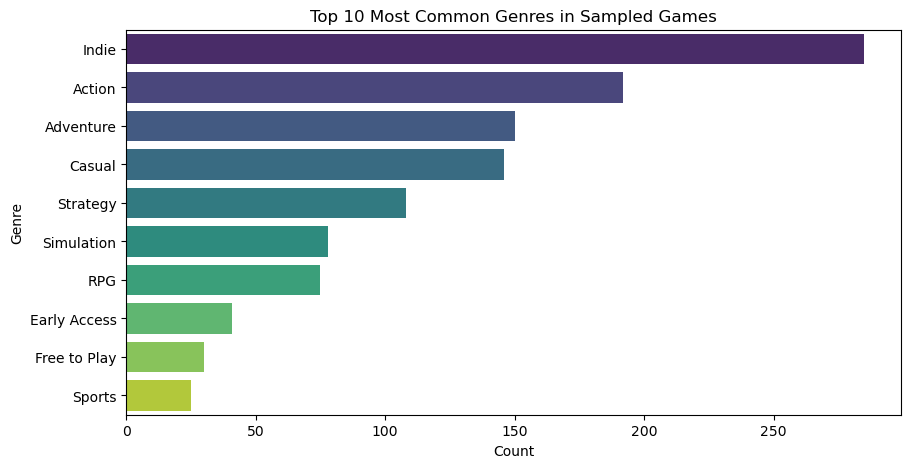

In [12]:
from collections import Counter

# Collect genres from matched games (those appearing in review sample)
all_genres = []
for g in game_index.values():
    genres = g.get("genres") or []
    # Some files store this as a string "Action, RPG" — handle both
    if isinstance(genres, str):
        genres = [x.strip() for x in genres.split(",")]
    all_genres.extend(genres)

genre_counts = Counter(all_genres)

# Convert to DataFrame for plotting
genre_df = pd.DataFrame(genre_counts.most_common(10), columns=["genre", "count"])

plt.figure(figsize=(10, 5))
sns.barplot(data=genre_df, y="genre", x="count", palette="viridis")
plt.title("Top 10 Most Common Genres in Sampled Games")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.show()

Across the sample, indie, action, and adventure are the most common genres of the games reviewed.

### Hours Played Distribution

In [15]:
# Clean hours column
df["hours"] = pd.to_numeric(df["hours"], errors="coerce")

df["hours"].describe()

count    49954.000000
mean        78.427671
std        259.992598
min          0.000000
25%          2.700000
50%         11.500000
75%         47.500000
max      14153.500000
Name: hours, dtype: float64

That's a huge range of hours played (from Steam reviews) from this sample.

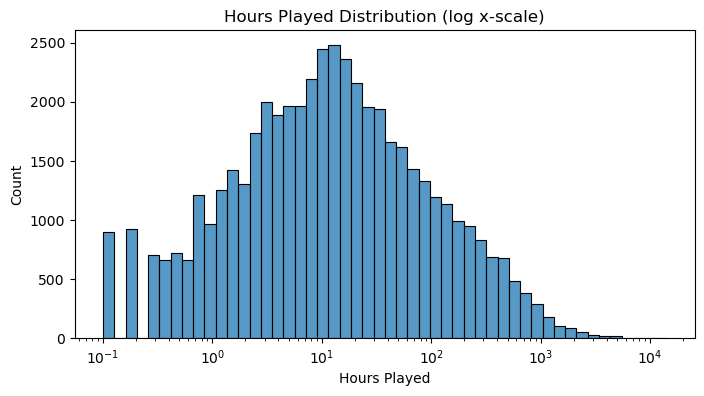

In [16]:
plt.figure(figsize=(8, 4))
sns.histplot(df["hours"].dropna(), bins=50, log_scale=(True, False))
plt.title("Hours Played Distribution (log x-scale)")
plt.xlabel("Hours Played")
plt.ylabel("Count")
plt.show()

The number of hours played by the users that left reviews is also extremely heavy-tailed. Most reviewers play very few hours but a small portion of them play an enormous number of hours. Orders of magnitude larger, even.

### Review Length Distribution

In [17]:
df["text"] = df["text"].fillna("")
df["text_len"] = df["text"].str.len()

In [18]:
df["text_len"].describe()

count    50000.000000
mean       323.114120
std        626.686043
min          0.000000
25%         39.000000
50%        115.000000
75%        331.000000
max       8000.000000
Name: text_len, dtype: float64

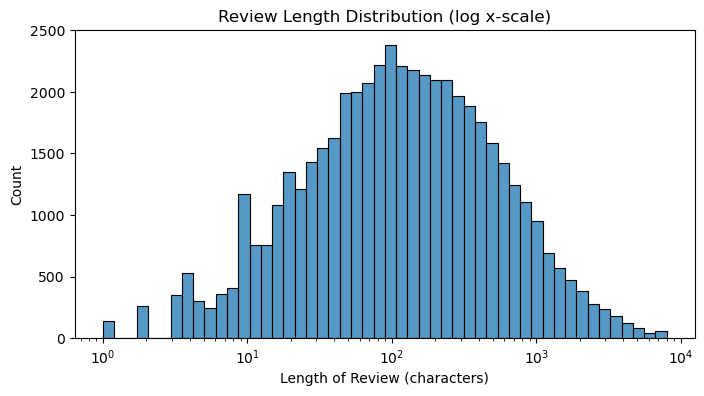

In [19]:
plt.figure(figsize=(8, 4))
sns.histplot(df["text_len"].replace(0, None).dropna(), bins=50, log_scale=(True, False))
plt.title("Review Length Distribution (log x-scale)")
plt.xlabel("Length of Review (characters)")
plt.ylabel("Count")
plt.show()

## Missingness

In [27]:
import numpy as np
import pandas as pd

# Basic missingness summary
missing_frac = df.isna().mean().sort_values(ascending=False)
missing_cnt  = df.isna().sum().sort_values(ascending=False)

missing_summary = pd.DataFrame({
    "n_missing": missing_cnt,
    "frac_missing": missing_frac
})

missing_summary

,n_missing,frac_missing
game_discount_price,49987,0.99974
compensation,48805,0.97610
found_funny,41854,0.83708
user_id,29981,0.59962
game_metascore,23936,0.47872
game_publisher,899,0.01798
game_price,471,0.00942
products,85,0.00170
game_genres,54,0.00108
hours,46,0.00092


`game_discount_price` is almost completely missing from our sample. 

Luckily, `game_genres`, `game_specs`, `game_tags`, etc. arethat afected.